Dataset shape: (518, 72)
Columns:
 ['Quarter', 'State', 'Total_Crashes', 'Num_Injured', 'Num_Killed', 'Total_Vehicles_Involved', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors', 'Quarter_Num', 'Year', 'Quarter_Date', 'Total_Casualties', 'Casualty_Rate', 'Fatality_Rate', 'Vehicles_per_Crash', 'Total_Factors', 'SPV_Prop', 'DAD_Prop', 'PWR_Prop', 'FTQ_Prop', 'Other_Factors_Prop', 'Quarter_Sin', 'Quarter_Cos', 'Severe_Crash', 'High_Casualty', 'State_Encoded', 'State_Adamawa', 'State_Akwa Ibom', 'State_Anambra', 'State_Bauchi', 'State_Bayelsa', 'State_Benue', 'State_Borno', 'State_Cross River', 'State_Delta', 'State_Ebonyi', 'State_Edo', 'State_Ekiti', 'State_Enugu', 'State_FCT', 'State_Gombe', 'State_Imo', 'State_Jigawa', 'State_Kaduna', 'State_Kano', 'State_Katsina', 'State_Kebbi', 'State_Kogi', 'State_Kwara', 'State_Lagos', 'State_Nasarawa', 'State_Niger', 'State_Ogun', 'State_Ondo', 'State_Osun', 'State_Oyo', 'State_Plateau', 'State_Rivers', 'State_Sokoto', 'State_Taraba', 'State_Yobe', 'St

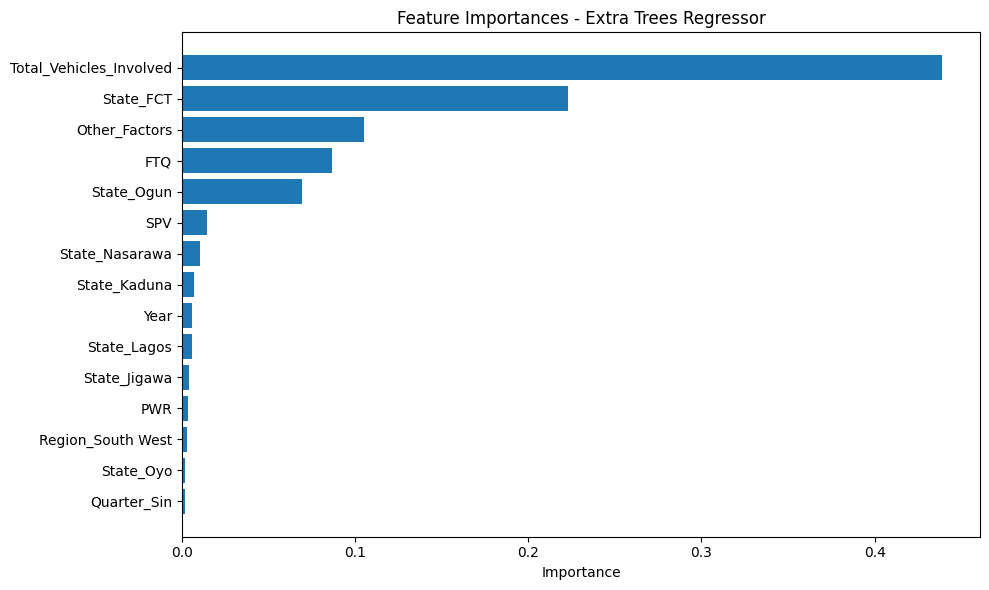

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load the dataset
# ------------------------------
# (Assuming the CSV content is saved as 'Nigeria_Crash_Data_P.csv')
df = pd.read_csv('Nigeria Crash Data P.csv')

print("Dataset shape:", df.shape)
print("Columns:\n", df.columns.tolist())

# ------------------------------
# 2. Define target and feature set
# ------------------------------
# Target: Total number of crashes per state-quarter
target = 'Total_Crashes'

# Identify columns that are direct derivatives of the target or represent
# outcomes that would not be known beforehand. These are EXCLUDED.
leakage_cols = [
    'Num_Injured', 'Num_Killed', 'Total_Casualties', 'Casualty_Rate',
    'Fatality_Rate', 'Vehicles_per_Crash', 'Severe_Crash', 'High_Casualty',
    'Total_Factors', 'SPV_Prop', 'DAD_Prop', 'PWR_Prop', 'FTQ_Prop',
    'Other_Factors_Prop'
]

# Also drop identifiers, free‑text columns, and redundant encoded forms.
id_cols = ['Quarter', 'State', 'Quarter_Date', 'Region', 'Region_Encoded', 'State_Encoded']

# Keep only predictor columns that are not in the above exclusion lists.
# Additionally, keep the already one‑hot encoded state and region dummies.
# We'll keep all columns that are Boolean (state/region indicators) plus
# the numeric raw counts and temporal features.
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
feat_candidates = [
    'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors',      # raw factor counts
    'Total_Vehicles_Involved',                        # vehicles involved
    'Quarter_Num', 'Year', 'Quarter_Sin', 'Quarter_Cos'  # temporal
] + bool_cols

# Final feature set: ensure all selected columns exist in df
features = [col for col in feat_candidates if col in df.columns]

X = df[features]
y = df[target]

print("\nFeatures used:", features)
print("X shape:", X.shape)

# ------------------------------
# 3. Train / Test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# ------------------------------
# 4. Train Extra Trees Regressor
# ------------------------------
etr = ExtraTreesRegressor(
    n_estimators=100,        # 100 trees
    random_state=42,
    n_jobs=-1               # use all processors
)
etr.fit(X_train, y_train)

# ------------------------------
# 5. Evaluate
# ------------------------------
y_pred = etr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Evaluation on Test Set ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")

# ------------------------------
# 6. Feature Importance
# ------------------------------
importances = etr.feature_importances_
indices = np.argsort(importances)[::-1]

# Display top 15 features
print("\nTop 15 important features:")
for i in range(15):
    print(f"{i+1:2d}. {features[indices[i]]:25s} {importances[indices[i]]:.4f}")

# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importances - Extra Trees Regressor")
plt.barh(range(15), importances[indices][:15][::-1], align='center')
plt.yticks(range(15), [features[indices[i]] for i in range(14, -1, -1)])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()